In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

### Loading data
For the moment, every profile is stored in a ``pickle`` format. Let's see what the data looks like.

In [202]:
import os
import glob
files = glob.glob('profiles/*.pkl')

with open(files[0], 'rb') as f:
    out = pickle.load(f)

print(f'{type(out)=}')
print(f'{len(out)=}')

type(out)=<class 'dict'>
len(out)=53


We have a dictionary where every key refers to a SMP profile. Every profile is a dataframe with as many rows as there is depths observation, and columns give information on the properties of the snow.

In [231]:
profile = out['SMP_142']
profile.columns

Index(['distance', 'force_median', 'fmax', 'L2012_lambda', 'L2012_f0',
       'L2012_delta', 'L2012_L', 'npeaks', 'B2009_psi', 'gradient_psi',
       'delta_bellaire', 'delta_bellairef5', 'layer'],
      dtype='object')

Plotting one profile shows us where the weak layer is with respect to some other parameters:

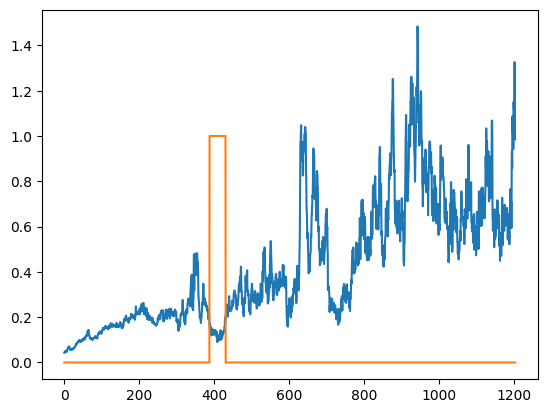

In [71]:
plt.plot(profile['distance'], profile['fmax'])
plt.plot(profile['distance'], profile['layer'] == 'WL')

What can looking at a bunch of different profiles tell us?

Text(0, 0.5, 'depth')

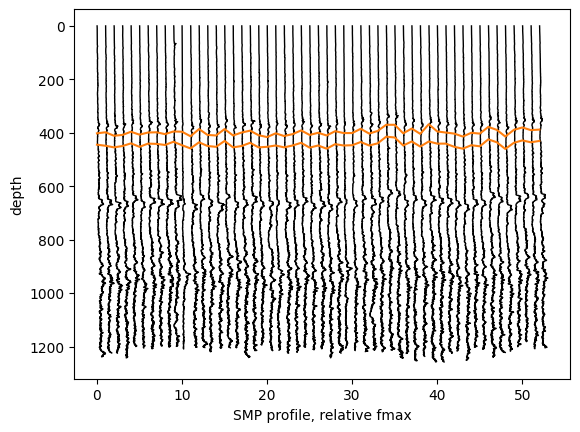

In [230]:
wl = []

for i, (key, profile) in enumerate(out.items()):
    z = profile['distance']
    fmax = profile['fmax']

    weak_layer = np.where(profile['layer'] == 'WL')[0]
    wl0 = weak_layer[0]
    wl1 = weak_layer[-1]
    wl.append(z[[wl0, wl1]])

    fmax = fmax/np.abs(fmax).max()

    plt.plot(fmax + i, z, c='k', lw=1)

plt.plot(wl, c='tab:orange')
plt.gca().invert_yaxis()

plt.xlabel('SMP profile, relative fmax')
plt.ylabel('depth')

Looking at multiple profiles in this manner, we learn that:
- For a given survey, the weak layer is relatively constant. Therefore, we cannot use depth solely as an indicator as it won't do a really good job at generalizing. 
- The depths are varying - this will need to be accounted for when using a U-Net or some other DL architecture.

Let's define some helper functions that will help us manipulate our data. For now, computing a few rolling windows of the available data will help us easily generate features to work with.

In [314]:
import pandas as pd

def rolling_windows(X, nwindow):
    rolling = X.rolling(nwindow)

    mean = rolling.mean()
    mean.columns = mean.columns + f'_mean_rolling_{nwindow}'

    std = rolling.std()
    std.columns = std.columns + f'_std_rolling_{nwindow}'

    skew = rolling.skew()
    skew.columns = skew.columns + f'_skew_rolling_{nwindow}'

    kurt = rolling.kurt()
    kurt.columns = kurt.columns + f'_kurt_rolling_{nwindow}'

    df = pd.concat([mean, std, skew, kurt], axis=1)
    df = df.fillna(0)

    return df


def profile_to_data(profile, nwindow=None):
    X = profile.iloc[:, 1:-1]

    if nwindow is not None:
        if isinstance(nwindow, int):
            nwindow = [nwindow]
        
        for n in nwindow:
            roll = rolling_windows(X, n)

            X = pd.concat([X, roll], axis=1)

    y = (profile['layer'] == 'WL').astype(int)

    return X, y

def pickle_to_data(out, nwindow=100):
    X = pd.DataFrame()
    y = pd.DataFrame()

    for key in out.keys():
        profile = out[key]
        Xi, yi = profile_to_data(profile, nwindow=nwindow)

        
        X = pd.concat([X, Xi], ignore_index=True)
        y = pd.concat([y, yi], ignore_index=True)
        
    return X, y

X, y = pickle_to_data(out, nwindow=100)

X

,force_median,fmax,L2012_lambda,L2012_f0,L2012_delta,L2012_L,npeaks,B2009_psi,gradient_psi,delta_bellaire,...,fmax_kurt_rolling_100,L2012_lambda_kurt_rolling_100,L2012_f0_kurt_rolling_100,L2012_delta_kurt_rolling_100,L2012_L_kurt_rolling_100,npeaks_kurt_rolling_100,B2009_psi_kurt_rolling_100,gradient_psi_kurt_rolling_100,delta_bellaire_kurt_rolling_100,delta_bellairef5_kurt_rolling_100
0,0.022440,0.029493,7391.543457,0.000825,0.007190,0.138494,1023.685896,0.043017,0.004652,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.023081,0.032057,6404.024039,0.000957,0.007474,0.145275,930.347651,0.045342,0.009270,0.010037,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.025646,0.037186,5585.021916,0.001209,0.007386,0.152055,849.232392,0.052287,0.008174,0.021579,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.026928,0.041033,6908.580593,0.001074,0.007221,0.141649,978.593925,0.053516,-0.005782,-0.025416,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.029493,0.041033,8421.893513,0.000818,0.008424,0.132599,1116.734142,0.046504,-0.008876,-0.060068,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129105,0.907220,1.325888,1754.518067,0.016938,0.061827,0.223678,392.447765,0.338534,-0.049681,-0.019679,...,2.401312,3.588239,0.715666,7.835343,2.506313,1.170199,1.104986,-0.514904,0.383849,95.935887
129106,0.870034,1.325888,280.037567,0.039084,0.161588,0.412355,115.474873,0.229855,-0.041904,-0.016455,...,2.405356,3.670477,3.314822,6.671667,2.172743,1.202302,1.000355,-0.506705,0.401130,95.935887
129107,0.734111,1.320759,395.999265,0.040035,0.095954,0.367377,145.480980,0.296630,-0.015596,-0.006095,...,2.209893,3.588483,4.204935,6.514205,1.930328,1.141529,0.825818,-0.497744,0.443670,95.935887
129108,0.759116,0.984799,827.228545,0.017696,0.102780,0.287388,237.735281,0.214259,0.009346,0.004856,...,1.929925,3.631465,4.149882,6.247938,1.938021,1.176373,0.814284,-0.498523,0.444944,95.935887


For one survey, concatenating every profile results in a large amount of rows! Let's see what the data looks like.

Text(1, 0    96.197041
dtype: float64, '124200.0')

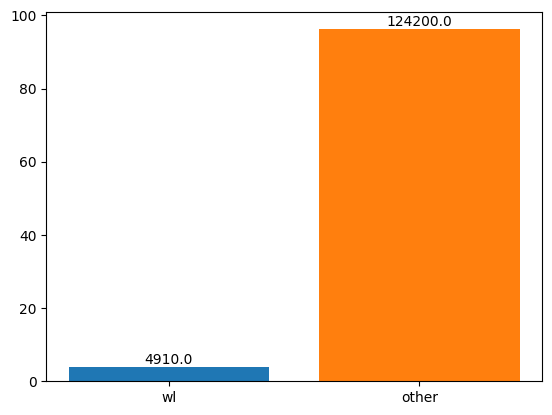

In [315]:
# the data is really imbalanced! we will need to deal with this if we use a random forest or xgboost
n_wl = y.sum()
n_other = len(y) - n_wl
ntot = len(y)

plt.bar(0, 100 * n_wl/ntot)
plt.bar(1, 100 * n_other/ntot)
plt.xticks([0, 1], ['wl', 'other'])

plt.text(0, 100 * n_wl/ntot, n_wl[0], ha='center', va='bottom')
plt.text(1, 100 * n_other/ntot, n_other[0], ha='center', va='bottom')

Text(0, 0.5, 'pca2')

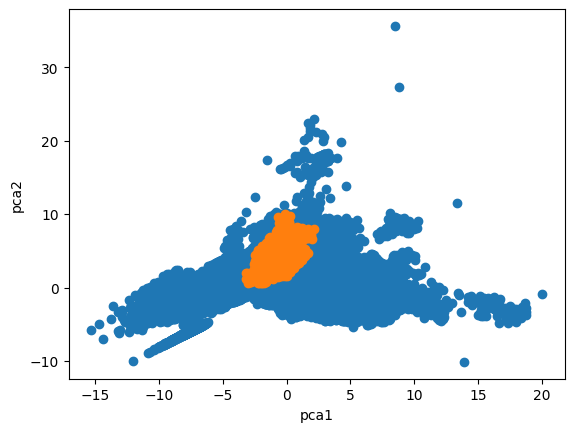

In [316]:
# there doesn't seem to be a clear, linear transformation that easily splits the data!
from sklearn.decomposition import PCA

mu = (X - X.mean())/X.std()
pca = PCA()
Z = pca.fit_transform(mu)

isweak = y.astype(bool).values.reshape(-1)
plt.scatter(Z[~isweak, 0], Z[~isweak, 1])
plt.scatter(Z[isweak, 0], Z[isweak, 1])

plt.xlabel('pca1')
plt.ylabel('pca2')

Enough playing around - let's try a simple model and see what it brings.

In [317]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1), test_size=0.33, random_state=42069)
clf = XGBClassifier()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [318]:
# how does the model fare?
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print(f'training score is {train_score:.2f}')
print(f'testing score is {test_score:.2f}')

training score is 1.00
testing score is 1.00


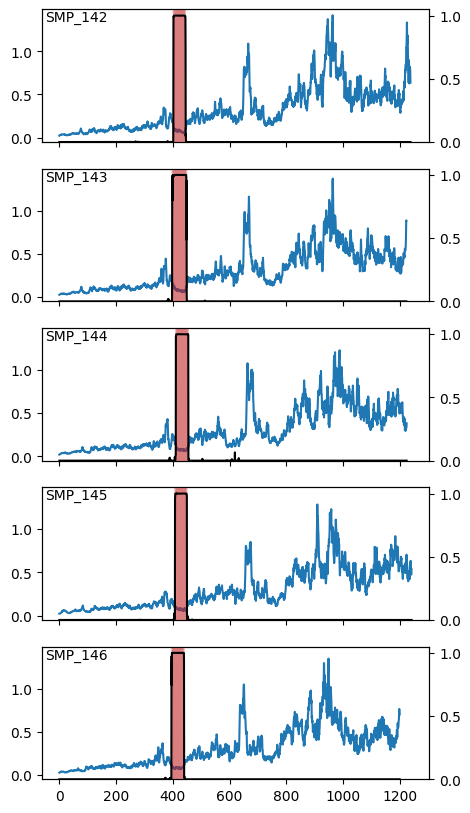

In [320]:
# the training and testing score are too good to be true! let's look at a few profiles to see what's going on
imax = 5

fig, axs = plt.subplots(imax, 1, sharex='all', sharey='all', figsize=(5, 10))
for i, (key, profile) in enumerate(out.items()):

    if i == imax:
        break

    xi, yi = profile_to_data(profile, nwindow=100)
    yi_hat = clf.predict_proba(xi)[:, 1]

    ax = axs[i]
    ax.text(0.01, 0.99, key, ha='left', va='top', transform=ax.transAxes)
    ax.plot(profile['distance'], profile['force_median'])
    ax2 = ax.twinx()
    ax2.vlines(profile['distance'][yi.astype(bool)], 0, 1.05, colors='tab:red', alpha=0.05)
    ax2.plot(profile['distance'], yi_hat, c='k')
    ax2.set_ylim(0, 1.05)

0.9946938775510205

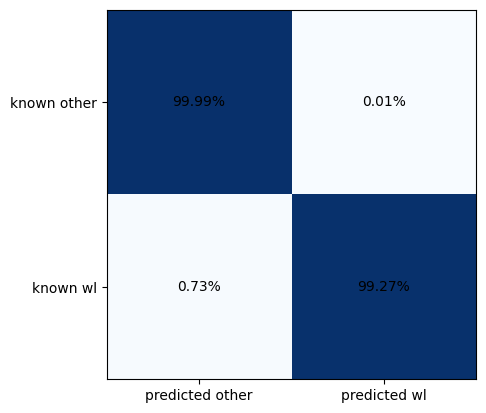

In [331]:
# the model picks the weak layer correctly, but it is probably uneable to generalize for now. let's look at the confusion matrix
from sklearn.metrics import confusion_matrix, f1_score

confmat = confusion_matrix(y, clf.predict(X), normalize='true')

fig, ax = plt.subplots()
ax.imshow(confmat, cmap='Blues')
ticks = np.arange(len(y.iloc[:, 0].unique()))
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_yticklabels(['known other', 'known wl'])
ax.set_xticklabels(['predicted other', 'predicted wl'])

for i in ticks:
    for j in ticks:
        ax.text(j, i, f'{100 * confmat[i, j]:.2f}%', ha='center', va='center')

f1 = f1_score(y, clf.predict(X))
f1

How does it do with some survey it has never seen?

In [332]:
import os
import glob
files = glob.glob('profiles/*.pkl')

with open(files[1], 'rb') as f:
    out2 = pickle.load(f)

X2, y2 = pickle_to_data(out2, nwindow=100)

score = clf.score(X2, y2)
print(f'overall score is {score:.2f}')

overall score is 0.96


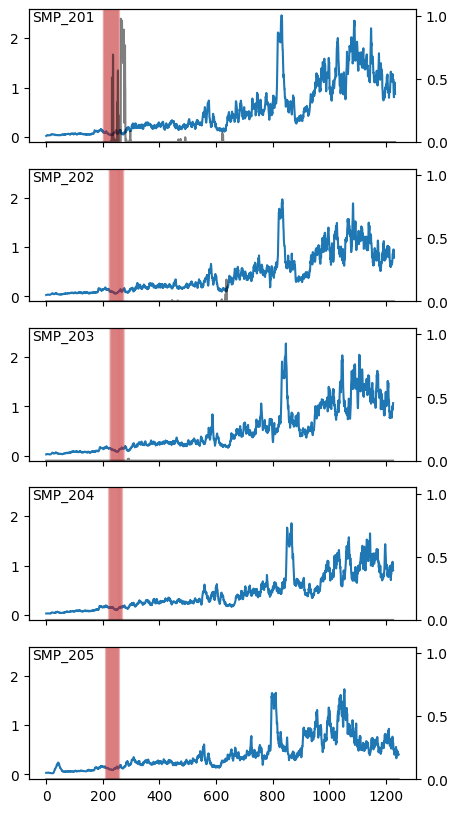

In [334]:
# the training and testing score are too good to be true! let's look at a few profiles to see what's going on
imax = 5

fig, axs = plt.subplots(imax, 1, sharex='all', sharey='all', figsize=(5, 10))
for i, (key, profile) in enumerate(out2.items()):

    if i == imax:
        break

    xi, yi = profile_to_data(profile, nwindow=100)
    yi_hat = clf.predict_proba(xi)[:, 1]

    ax = axs[i]
    ax.text(0.01, 0.99, key, ha='left', va='top', transform=ax.transAxes)
    ax.plot(profile['distance'], profile['force_median'])
    ax2 = ax.twinx()
    ax2.vlines(profile['distance'][yi.astype(bool)], 0, 1.05, colors='tab:red', alpha=0.05)
    ax2.plot(profile['distance'], yi_hat, c='k', alpha=0.5)
    ax2.set_ylim(0, 1.05)

That's reassuring! We might try with more data, training on more than one survey at a time. If it doesn't work too well, we can also try some U-Net architecture 🤯

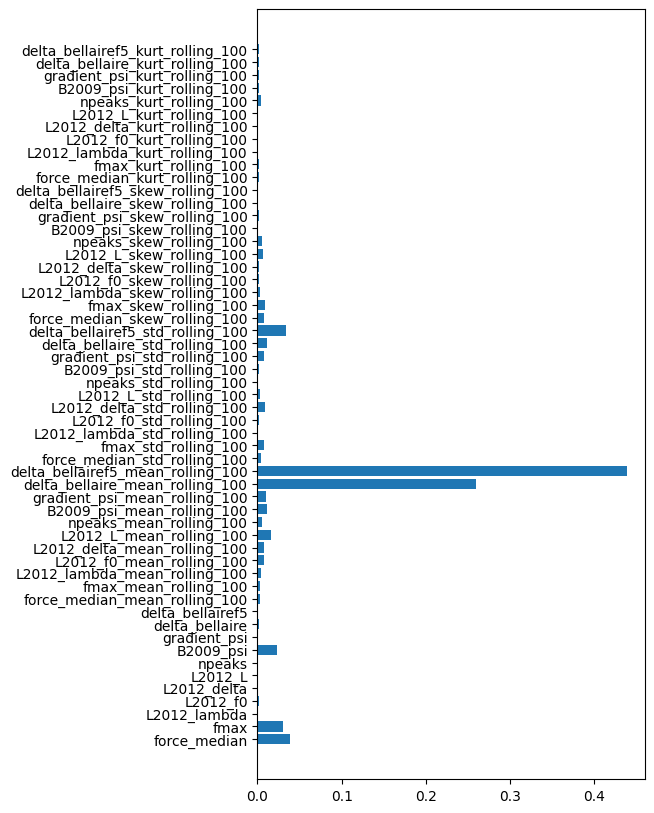

In [335]:
plt.figure(figsize=(5, 10))
ticks = np.arange(len(clf.feature_importances_))
plt.barh(ticks, clf.feature_importances_)
_ = plt.yticks(ticks, X.columns)